# Установка нужных библиотек

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

# try:
#     import google.colab
#     IN_COLAB = True
# except:
#     IN_COLAB = False
    
# if IN_COLAB:
#     !git clone -qq https://github.com/Intelligent-Systems-Phystech/ProjectTemplate.git /tmp/repo
#     !python3 -m pip install -qq /tmp/repo/src/ && rm -rf /tmp/repo

# Импорт библиотек

In [17]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchsde as tsde
from torchdiffeq import odeint

from typing import Tuple, Union, List

# Настройка окружения

In [3]:
# sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (14, 8)

SEED = 42
IN_COLAB = False

if IN_COLAB:
    figures_dir = './'
else:
    figures_dir = '../figures/'

# Работа с данными

**Функция для 2D- и 3D-визуализации**

In [25]:
def plot_phase_trajectory(points: Union[np.ndarray, Tuple[np.ndarray]],
                          name: str = '',
                          labels: List[str] = [''],
                          mode: str = '3D',
                          use_lines: bool = False, 
                          clear: bool = True,
                          to_save: bool = False):
    assert mode in ['2D', '3D'], 'mode must be in [2D, 3D]'
    
    fig = plt.figure()
    ax = None
    
    if isinstance(points, np.ndarray):
        points = points, 
        
    assert len(labels) == len(points), f'{len(labels)} != {len(points)}'
    
    if mode == '3D':
        ax = fig.add_subplot(projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        
        for i in range(len(points)):
            xs = points[i][:,0]
            ys = points[i][:,1]
            zs = points[i][:,2]
            
            if use_lines:
                ax.plot(xs, ys, zs, alpha=0.5)

            ax.scatter(xs, ys, zs, label=labels[i])
    else:
        ax = fig.add_subplot()
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        for i in range(len(points)):
            xs = points[i][:,0]
            ys = points[i][:,1]
            
            if use_lines:
                ax.plot(xs, ys, alpha=0.5)

            ax.scatter(xs, ys, label=labels[i])
        
    # Remove ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    
    if mode == '3D':
        ax.zaxis.set_ticks([])
    
    if clear:
        # First remove fill
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        # Now set color to white (or whatever is "invisible")
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')

        # Remove axis
        ax.set_axis_off()

        # Bonus: To get rid of the grid as well:
        ax.grid(False)
        
    ax.legend()

    if to_save:
        fig.savefig(figures_dir + name + '.png')
        
    ax.set_title(name)
    plt.show()

**Создание синтетического датасета - спирали**

In [5]:
# Parameters of lorenz system of diff. equations
LORENZ_RHO = 28
LORENZ_SIGMA = 10
LORENZ_BETA = 8/3

DATA_SIZE = 1000
INITIAL_POINT_2D = (1., -1.)
INITIAL_POINT_3D = (1., -1., 1.)
T = 25.

class Spiral(nn.Module):
    DIM = 2
    
    def __init__(self, mat: torch.Tensor):
        assert mat.shape == (self.DIM, self.DIM)
        
        super().__init__()
        self.mat = mat
        
    def forward(self, ts: torch.Tensor, inp: torch.Tensor) -> torch.Tensor:
        return inp**3 @ self.mat


class LorenzAttractor(nn.Module):
    DIM = 3
    
    def __init__(self,
                 rho: int = LORENZ_RHO,
                 sigma: int = LORENZ_SIGMA,
                 beta: int = LORENZ_BETA):
        super().__init__()
        
        self.rho = rho
        self.sigma = sigma
        self.beta = beta
    
    def forward(self, time: torch.Tensor, inp: torch.Tensor):
        if inp.size().numel() != self.DIM:
            raise ValueError(f'Input size != {self.DIM}')
        
        x, y, z = torch.split(inp, 1)
        dxdt = self.sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - self.beta * z
        
        return torch.stack([dxdt, dydt, dzdt]).reshape(-1).to(inp.device)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ts = torch.linspace(0., T, DATA_SIZE).to(device)
y0 = torch.tensor(INITIAL_POINT_2D).to(device)
mat = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

with torch.no_grad():
    spiral_data = odeint(Spiral(mat), y0, ts, method='dopri5')

**Отрисовка полученных данных**

No handles with labels found to put in legend.


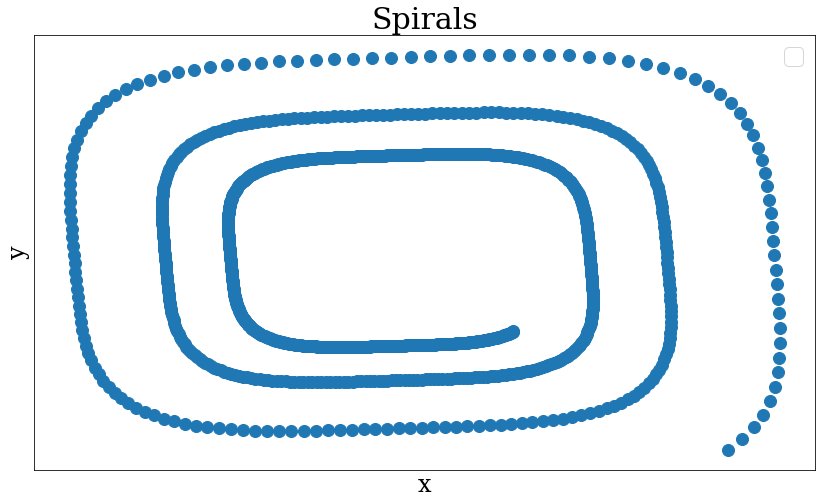

In [26]:
plot_phase_trajectory(
    spiral_data.numpy(), 
    name='Spirals',
    mode='2D',
    to_save=True,
    clear=False,
)

**Функция, генерирующая батчи для обучения модели**

In [7]:
def get_batch(data: torch.Tensor, 
              ts: torch.Tensor, 
              batch_size: int, 
              batch_time: int) -> Tuple[torch.Tensor]:
    assert data.ndim == 2 and ts.ndim == 1
    assert data.shape[0] == ts.shape[0]
    
    data_size = data.shape[0]
    start_indices = torch.from_numpy(
        np.random.choice(
            np.arange(
                data_size-batch_time,
                dtype=np.int64
            ), 
            batch_size, 
            replace=False
        )
    )
    # batch_t = (batch_time,)
    # batch_y0 = (batch_size, y0_dim)
    # batch_y = (batch_time, batch_size, y0_dim)
    batch_y0 = data[start_indices]
    batch_t = ts[:batch_time]
    batch_y = torch.stack(
        [data[start_indices + i] for i in range(batch_time)], 
        dim=0
    )
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

**Модель, параметризующая производную скрытого состояния**

In [8]:
class LorenzFunc(nn.Module):
    def __init__(self, hid_dim: int):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(3, hid_dim),
            nn.Tanh(),
            nn.Linear(hid_dim, hid_dim//2),
            nn.Tanh(),
            nn.Linear(hid_dim//2, 3)
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, ts: torch.Tensor, inp: torch.Tensor) -> torch.Tensor:
        if inp.ndim == 1:
            inp = inp.reshape(1, -1)
        
        xy_prod = inp[:, 0] * inp[:, 1]
        xz_prod = inp[:, 0] * inp[:, 2]
        concatenated = torch.hstack(
            (inp, xy_prod.unsqueeze(1), xz_prod.unsqueeze(1))
        )
        return self.net(concatenated)
    
class SpiralFunc(nn.Module):
    def __init__(self, hid_dim: int):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(2, hid_dim),
            nn.Tanh(),
            nn.Linear(hid_dim, 2)
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, ts: torch.Tensor, inp: torch.Tensor) -> torch.Tensor:
        return self.net(inp**3)

**Обучение модели**

In [63]:
N_ITERS = 500
TEST_FREQ = 20
BATCH_SIZE = 60
BATCH_TIME = 40
HID_DIM = 50

func = SpiralFunc(HID_DIM).to(device)
optimizer = optim.Adam(
    func.parameters(),
    lr=0.005,
    weight_decay=0.01
)
train_loss_arr = []
val_loss_arr = []

for itr in range(1, N_ITERS+1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(
        spiral_data,
        ts,
        BATCH_SIZE,
        BATCH_TIME
    )
    pred_y = odeint(func, batch_y0, batch_t, rtol=1e-4, atol=1e-6).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr % TEST_FREQ != 0:
        train_loss_arr.append(loss.item())
        continue
        
    with torch.no_grad():
        pred_y = odeint(func, y0, ts, rtol=1e-4, atol=1e-6)
        loss = torch.mean(torch.abs(pred_y - spiral_data))
        val_loss_arr.append(loss.item())
        print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

Iter 0020 | Total Loss 0.537315
Iter 0040 | Total Loss 0.483240
Iter 0060 | Total Loss 0.042357
Iter 0080 | Total Loss 0.216223
Iter 0100 | Total Loss 0.288348
Iter 0120 | Total Loss 0.236895
Iter 0140 | Total Loss 0.081115
Iter 0160 | Total Loss 0.159127
Iter 0180 | Total Loss 0.188947
Iter 0200 | Total Loss 0.137381
Iter 0220 | Total Loss 0.058171
Iter 0240 | Total Loss 0.144766
Iter 0260 | Total Loss 0.127787
Iter 0280 | Total Loss 0.026247
Iter 0300 | Total Loss 0.032403
Iter 0320 | Total Loss 0.066350
Iter 0340 | Total Loss 0.022370
Iter 0360 | Total Loss 0.143527
Iter 0380 | Total Loss 0.029593
Iter 0400 | Total Loss 0.177983
Iter 0420 | Total Loss 0.049077
Iter 0440 | Total Loss 0.052065
Iter 0460 | Total Loss 0.055683
Iter 0480 | Total Loss 0.058978
Iter 0500 | Total Loss 0.033067


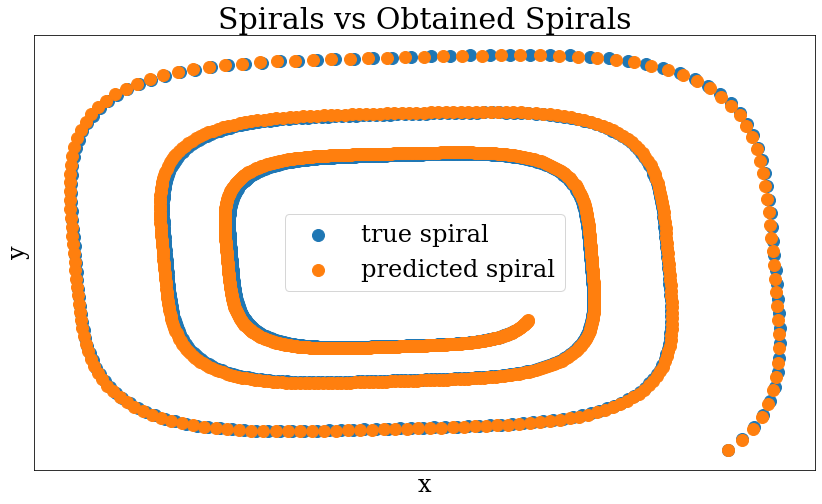

In [64]:
plot_phase_trajectory(
    (spiral_data.numpy(), pred_y.detach().numpy()), 
    name='Spirals vs Obtained Spirals',
    labels=['true spiral', 'predicted spiral'],
    mode='2D',
    to_save=False,
    clear=False,
)

**Добавление шума к данным**

In [53]:
noise = torch.normal(
    torch.zeros([DATA_SIZE, 2]),
    torch.full([DATA_SIZE, 2], 0.03)
)
noisy_spirals = spiral_data + noise

No handles with labels found to put in legend.


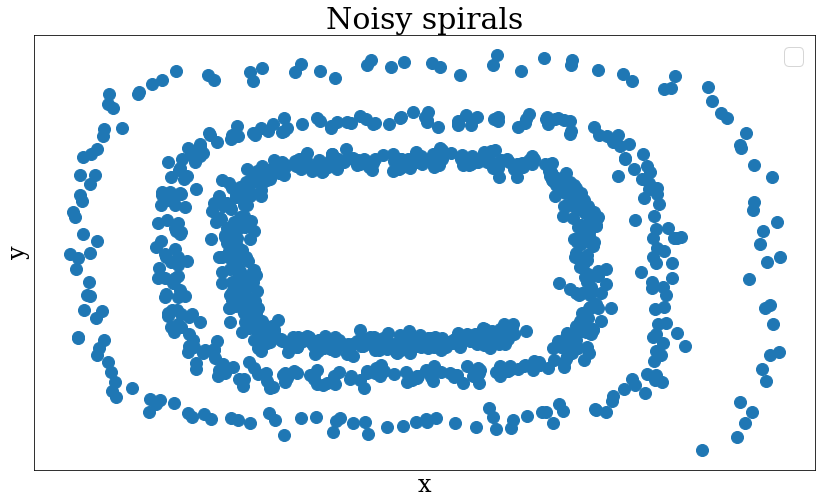

In [54]:
plot_phase_trajectory(
    noisy_spirals.numpy(), 
    name='Noisy spirals',
    mode='2D',
    to_save=True,
    clear=False,
)

**Обучение Neural ODE на зашумлённых данных**

In [65]:
func = SpiralFunc(HID_DIM).to(device)
optimizer = optim.Adam(
    func.parameters(),
    lr=0.005,
    weight_decay=0.01
)
noisy_train_loss_arr = []
noisy_val_loss_arr = []

for itr in range(1, N_ITERS+1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(
        noisy_spirals,
        ts,
        BATCH_SIZE,
        BATCH_TIME
    )
    pred_y = odeint(func, batch_y0, batch_t, rtol=1e-4, atol=1e-6).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr % TEST_FREQ != 0:
        noisy_train_loss_arr.append(loss.item())
        continue
        
    with torch.no_grad():
        pred_y = odeint(func, y0, ts, rtol=1e-4, atol=1e-6)
        loss = torch.mean(torch.abs(pred_y - noisy_spirals))
        noisy_val_loss_arr.append(loss.item())
        print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

Iter 0020 | Total Loss 0.537153
Iter 0040 | Total Loss 0.247524
Iter 0060 | Total Loss 0.566957
Iter 0080 | Total Loss 0.529690
Iter 0100 | Total Loss 0.585017
Iter 0120 | Total Loss 0.069963
Iter 0140 | Total Loss 0.186715
Iter 0160 | Total Loss 0.126201
Iter 0180 | Total Loss 0.408595
Iter 0200 | Total Loss 0.138955
Iter 0220 | Total Loss 0.629851
Iter 0240 | Total Loss 0.277928
Iter 0260 | Total Loss 0.235822
Iter 0280 | Total Loss 0.417721
Iter 0300 | Total Loss 0.580235
Iter 0320 | Total Loss 0.105249
Iter 0340 | Total Loss 0.543721
Iter 0360 | Total Loss 0.346519
Iter 0380 | Total Loss 0.437548
Iter 0400 | Total Loss 0.187027
Iter 0420 | Total Loss 0.371182
Iter 0440 | Total Loss 0.083319
Iter 0460 | Total Loss 0.049608
Iter 0480 | Total Loss 0.639941
Iter 0500 | Total Loss 0.166828


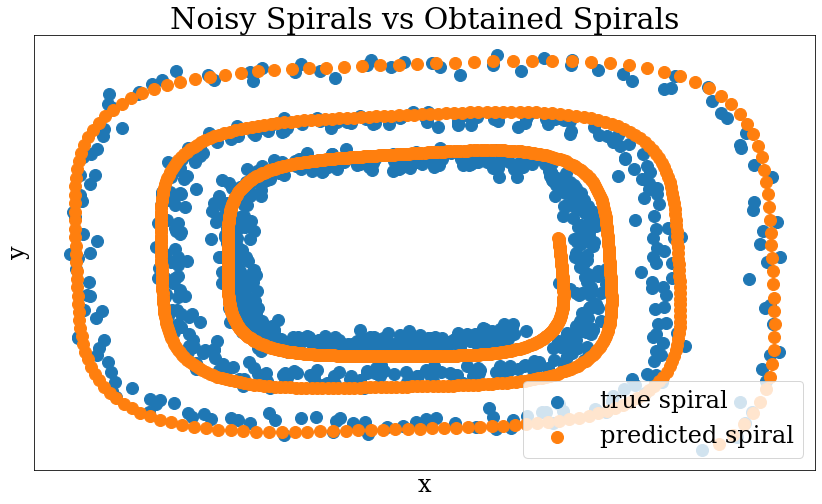

In [66]:
plot_phase_trajectory(
    (noisy_spirals.numpy(), pred_y.detach().numpy()), 
    name='Noisy Spirals vs Obtained Spirals',
    labels=['true spiral', 'predicted spiral'],
    mode='2D',
    to_save=False,
    clear=False,
)

**Обучение Neural SDE на зашумлённых данных**

In [96]:
class NoisySpiralFunc(nn.Module):
    def __init__(self, hid_dim: int):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor([[0.1, 0.1]]), requires_grad=True)
        self.drift = SpiralFunc(hid_dim)
        
        self.noise_type = "diagonal"
        self.sde_type = "ito"
    
    def f(self, ts: torch.Tensor, inp: torch.Tensor) -> torch.Tensor:
        return self.drift(ts, inp)
    
    def g(self, ts: torch.Tensor, inp: torch.Tensor) -> torch.Tensor:
        batch_size = inp.shape[0]
        return torch.tile(self.theta, (batch_size, 1))

In [97]:
func = NoisySpiralFunc(HID_DIM).to(device)
optimizer = optim.Adam(
    func.parameters(),
    lr=0.005,
    weight_decay=0.01
)
sde_train_loss_arr = []
sde_val_loss_arr = []

for itr in range(1, N_ITERS+1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(
        noisy_spirals,
        ts,
        BATCH_SIZE,
        BATCH_TIME
    )
    pred_y = tsde.sdeint_adjoint(func, batch_y0, batch_t, rtol=1e-4, atol=1e-6).to(device)
    loss = torch.mean(torch.square(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr % TEST_FREQ != 0:
        sde_train_loss_arr.append(loss.item())
        continue
        
    with torch.no_grad():
        pred_y = odeint(func, y0, ts, rtol=1e-4, atol=1e-6)
        loss = torch.mean(torch.square(pred_y - noisy_spirals))
        sde_val_loss_arr.append(loss.item())
        print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

KeyboardInterrupt: 